<h1>内容包括：</h1>

一.数据处理：

1.导入，索引，基本统计分析

2.频率重采样

3.数据分布

4.数据异常值处理

5.打标签生成y

二、数据特征：

1.Talib库介绍

2.数据特征构建

3.特征缩放和变换

4.特征相关性分析

5.特征重要性分析

<h1>一、数据处理和分析基本方法介绍</h1>

<h2>1.1 数据导入、索引、基本统计分析</h2>

                      Open   High    Low  Close  Volume        Std  \
datetime                                                             
2014-05-05 09:05:00  14285  14325  14200  14305   47436        NaN   
2014-05-05 09:10:00  14305  14470  14280  14375   46548        NaN   
2014-05-05 09:15:00  14370  14415  14360  14410   18904        NaN   
2014-05-05 09:20:00  14410  14430  14385  14400   14594        NaN   
2014-05-05 09:25:00  14405  14405  14380  14385    7664        NaN   
2014-05-05 09:30:00  14380  14410  14365  14400    9120        NaN   
2014-05-05 09:35:00  14400  14400  14360  14375   10452        NaN   
...                    ...    ...    ...    ...     ...        ...   
2018-11-09 13:40:00  11285  11300  11285  11285    2358  31.015191   
2018-11-09 13:45:00  11290  11315  11285  11315    3250  30.475979   
2018-11-09 13:50:00  11315  11315  11295  11305    2444  29.637642   
2018-11-09 13:55:00  11300  11325  11300  11310    3646  29.479477   
2018-11-09 14:00:00 

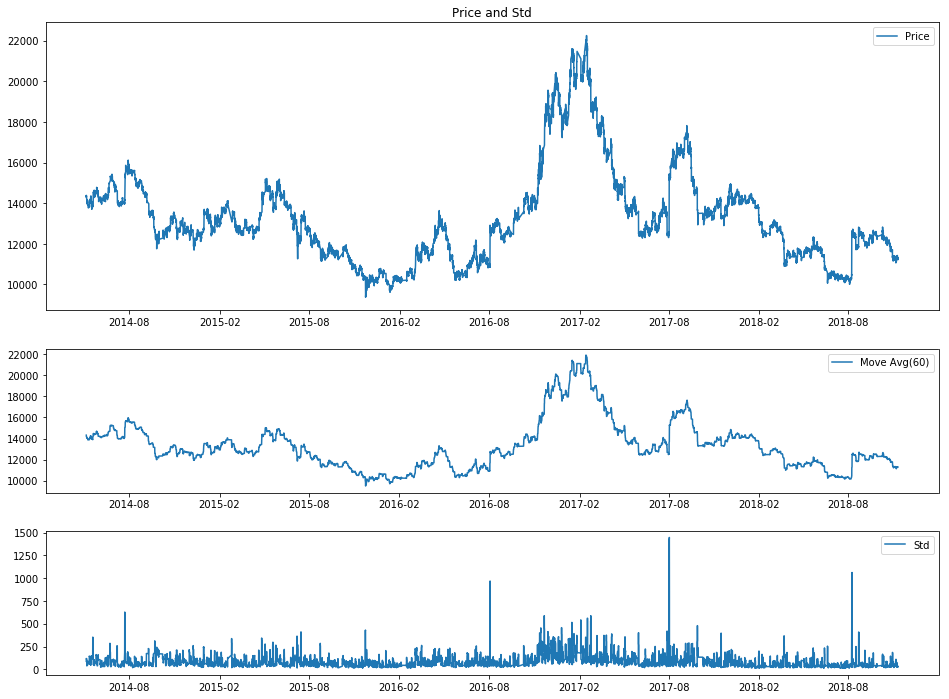

In [3]:
import numpy as np
import pandas as pd
import talib

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.finance import candlestick2_ohlc

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 50)

#获取数据，设置索引
def get_data(filename):
    data=pd.read_excel(filename)
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.set_index('datetime')
    return data

#基本统计函数
def basic_stats(data,featname,win):
    std =data[featname].rolling(win).std()
    mean=data[featname].rolling(win).mean()
    return std,mean
    
#画图
def plot_pic(data):
    gs1 = gridspec.GridSpec(3,1,height_ratios=[2,1,1])
    plt.figure(figsize=[16,12])
    ax1 = plt.subplot(gs1[0])
    plt.plot(data['Close'], label='Price')
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(handles1, labels1)
    #打印抬头
    plt.title('Price and Std')

    ax2 = plt.subplot(gs1[1])
    plt.plot(data['MA'], label='Move Avg(60)')
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles2, labels2)

    ax3 = plt.subplot(gs1[2])
    plt.plot(data['Std'], label='Std')
    handles3, labels3 = ax3.get_legend_handles_labels()
    ax3.legend(handles3, labels3)
    
    #plt.show()
    
    
filename='C:\\HiData\\Users\\ShenHong\\合作\\融秀\\AI量化初级\\notebook\\SHFE_ru_HOT_5.xlsx'
data=get_data(filename)
std,mean=basic_stats(data,'Close',60)
data['Std']=std
data['MA']=mean
print(data)
plot_pic(data)
plt.show()

<h2>1.2 时间序列分析</h2>
时间序列分析（time series analysis）是量化投资中的一门基本技术，时间序列是指在一定时间内按

时间顺序测量的某个变量的取值序列。比如变量是股票价格，那么它随时间的变化就是一个时间序列；

同样的，如果变量是股票的收益率，则它随时间的变化也是一个时间序列。时间序列分析就是使用统计

的手段对这个序列的过去进行分析，以此对该变量的变化特性建模、并对未来进行预测。时间序列分析

试图通过研究过去来预测未来。在量化投资领域，我们的目标是通过统计手段对投资品的收益率这个时间

序列建模，以此推断序列中不同交易日的收益率之间有无任何特征，以此来预测未来的收益率并产生交易

信号。


<h2>一个时间序列可能存在的特征包括以下几种：</h2>

1.趋势：趋势是时间序列在某一方向上持续运动（比如牛市时股市每天都在上涨，股票收益率持续为正；

熊市时股市每天都在下跌，股票收益率持续为负）。趋势经常出现在金融时间序列中，特别是大宗商品

价格。


2.季节变化：许多时间序列中包含季节变化。在金融领域，我们经常看到商品价格的季节性变化，特别是

那些与生长季节或温度变化有关的商品，比如天然气。


3.序列相关性：金融时间序列的一个最重要特征是序列相关性（serial correlation），又称为自相关性

（autocorrelation）。以投资品的收益率序列为例，我们会经常观察到一段时间内的收益率之间存在正

相关或者负相关。


4.随机噪声：它是时间序列中除去趋势、季节变化和自相关性之后的剩余随机扰动。由于时间序列存在不

确定性，随机噪声总是夹杂在时间序列中，致使时间序列表现出某种震荡式的无规律运动。

<h2>下图分析平稳序列和非平稳序列差异：</h2>

下图分析了平稳序列和非平稳序列的差异，对于平稳序列均值和方差是固定的，不是时间的函数，因此未来

是可以预测的，而非平稳序列则相反，均值和方差随着时间变化。

![](./timeseries.jpg "平稳序列与非平稳序列")


<h2>下面的代码用收益率序列，画出了收益率序列本身，其自相关性和正太性。

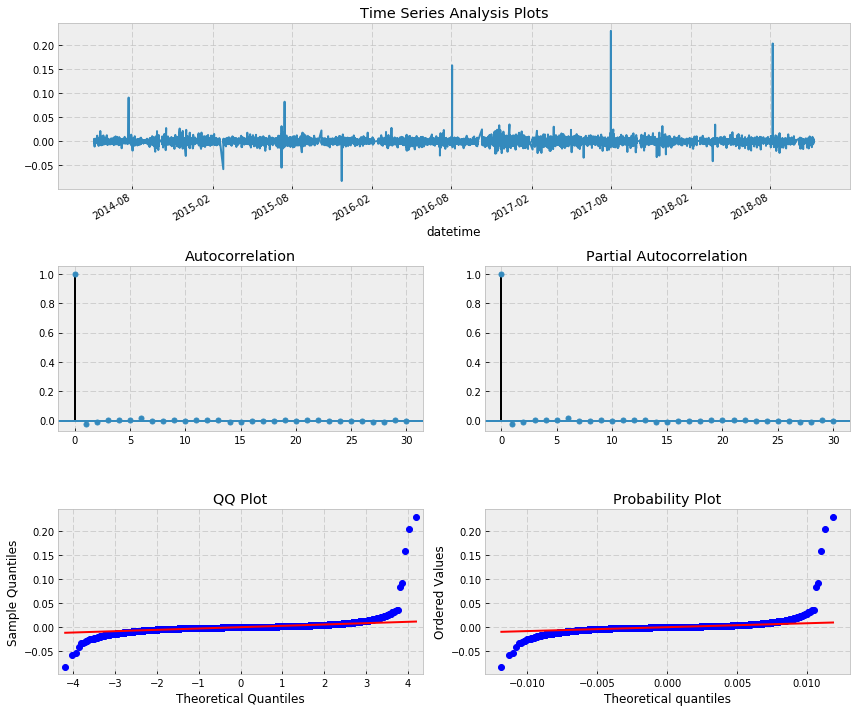

In [2]:
#时间序列分析画图函数
def tsplot(y, lags=None, figsize=(12, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        plt.show()
    return 

#对收益率序列进行时间序列相关性、正太性分析
returns=data['Close']/data['Close'].shift(1) - 1.0
returns=returns.fillna(method='bfill')
tsplot(returns,lags=30)

<h2>1.3 数据频率重采样</h2>

所谓频率重采样，指的是如果我们只有频率较高的数据，想要得到频率较低的数据，那么我们可以采用高频数据聚合的方式得到低频数据集。

比如，我们只有5分钟数据，但是我们想得到日频数据，就需要频率重采样函数。Pandas包提供了一套方法实现此功能，可以很方便地从高频

数据得到低频数据。

               Open     High      Low    Close  Volume         Std       MA
datetime                                                                   
2014-05-09  13950.0  13975.0  13755.0  13770.0  643906  222.794749  14045.0
2014-05-16  14045.0  14080.0  13635.0  13820.0  722082  174.699742  14087.0
2014-05-23  14450.0  14640.0  14310.0  14440.0  770142  102.627969  14428.0
2014-05-30  14275.0  14355.0  14070.0  14125.0  623690  232.039867  14434.0
2014-06-13  14050.0  14500.0  14045.0  14390.0  721820  108.742816  14275.0
2014-06-20  14590.0  15020.0  14540.0  14965.0  775554  288.496100  14484.0
2014-06-27  15335.0  15335.0  15060.0  15140.0  420976   84.602009  15262.0
...             ...      ...      ...      ...     ...         ...      ...
2018-09-14  12310.0  12400.0  12280.0  12385.0  247306  175.085693  12184.0
2018-09-21  12550.0  12615.0  12415.0  12465.0  285304  197.528479  12289.0
2018-10-12  12245.0  12390.0  12205.0  12325.0  307272  155.940694  12429.0
2018-10-19  

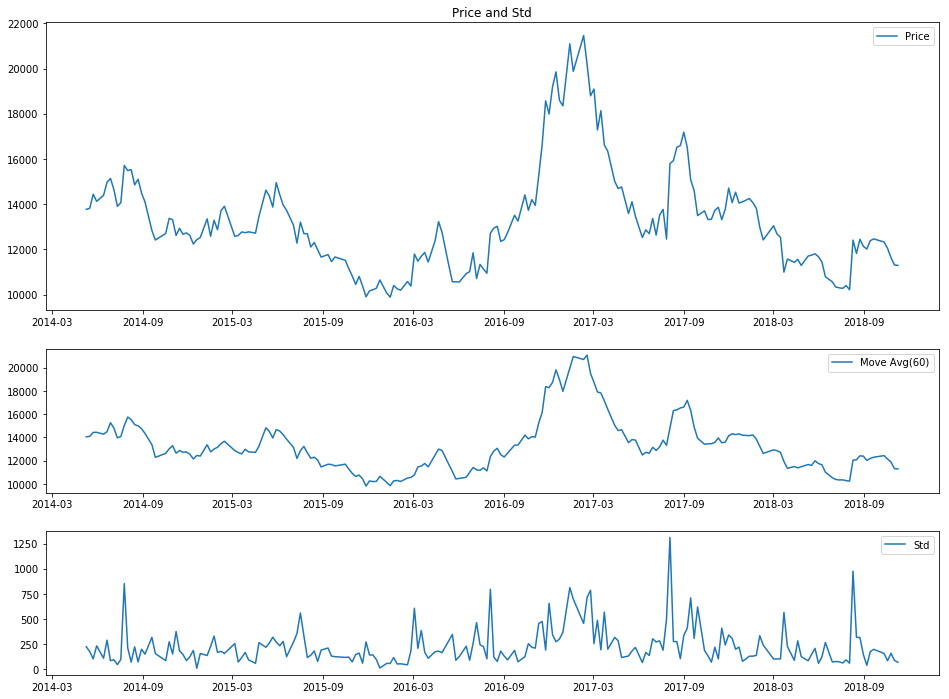

In [4]:
#高频数据汇总成低频数据，通过resample函数重采样，ohlc()函数生成指定列的open,high,low,close四个汇总字段
def high_2_Low(tmp, freq):
    """
    tmp:含Open,High,Low,Close,Volume字段的数据
    freq:目标频率：
    """
    # 分别处理bar数据
    tmp_open = tmp['Open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['High'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['Low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['Close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)

    # 处理成交量
    tmp_volume = tmp['Volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)
    
    res= pd.concat([tmp_price, tmp_volume], axis=1)
    res=res[['open','high','low','close','Volume']]
    res.columns=['Open','High','Low','Close','Volume']
    return res

data_day=high_2_Low(data,'1d')
day_std,day_mean=basic_stats(data_day,'Close',5)
data_day['Std']=day_std
data_day['MA']=day_mean
data_day=data_day.dropna(how='any')  #去掉非交易日
print(data_day)
plot_pic(data_day)
plt.show()

<h2>1.4 数据分布分析</h2>

在构建量化程序时，经常需要看某个序列的分布，比如收益率的分布情况，预测概率的分布情况，从而给策略创建和优化提供依据

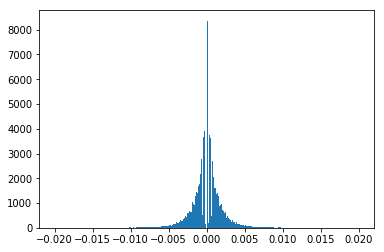

In [118]:
#查看序列的分布情况，可以看到大部分收益率接近0，收益率基本呈现正态分布
returns=data.Close/data.Close.shift(1) - 1.0  #5分钟bar的收益率
returns.dropna(how='any',inplace=True)
_ = plt.hist(returns.values,bins=300,range=[-0.02,0.02])
plt.show()

正态分布是自然界最基本最常见的一种分布，金融时间序列很多也符合正太分布。

如果想知道一个序列是否符合正太分布，那么可以针对这个序列进行正太性检验，

从下面针对收益率的检验可以看出，收益率序列不是严格符合正太分布。

In [40]:
#检验序列是否符合正太分布，可以采用scipy.stats.normaltest(a, axis=0, nan_policy=’propagate’)模块进行检验
#返回结果，如果p值大于0.5一般认为符合正态分布
from scipy.stats import normaltest
print('检验随机序列（结果符合正态分布）：')
n1=normaltest(np.random.normal(size=50000))
print(n1)
print()

print('检验收益率序列（结果不完全符合正太分布）：')
n2=normaltest(returns,axis=None)
print(n2)

检验随机序列（结果符合正态分布）：
NormaltestResult(statistic=1.7921884083588824, pvalue=0.40816074301889316)

检验收益率序列（结果不完全符合正太分布）：
NormaltestResult(statistic=146275.35831925404, pvalue=0.0)


<h2>1.5 数据异常值处理</h2>
数据经常会出现异常值，这些异常值有些是数据本身带入的也有一些是计算过程产生的，比如常见的缺失、空值。

因为很多模型不接受异常数据，针对异常值需要做一些处理，比如补缺，空值置换，使其符合建模的要求。

Pandas提供了丰富的异常值处理方法，这里主要介绍Pandas里面的方法

<h3>1.5.1 空值、无限大置换</h3>
空值替换：fillna()函数

值替换：  replace()函数

In [4]:
import talib
#对空值进行置换，置换成固定值，前值，后值
MA20=talib.MA(data['Close'],20)  #20日移动平均
print('替换前，序列的前部有些值为空：')
print(MA20)
print()

MA20=MA20.fillna(method='bfill') #‘bfill'含义是back fill用后面的值替换，相应的还有'ffill'含义是front fill用前面的值替换
print('替换后，序列的前部空值替换成后面非空第一个：')
print(MA20)

替换前，序列的前部有些值为空：
datetime
2014-05-05 09:05:00         NaN
2014-05-05 09:10:00         NaN
2014-05-05 09:15:00         NaN
2014-05-05 09:20:00         NaN
2014-05-05 09:25:00         NaN
2014-05-05 09:30:00         NaN
2014-05-05 09:35:00         NaN
                         ...   
2018-11-09 13:40:00    11306.00
2018-11-09 13:45:00    11307.50
2018-11-09 13:50:00    11308.50
2018-11-09 13:55:00    11307.50
2018-11-09 14:00:00    11306.50
2018-11-09 14:05:00    11305.00
2018-11-09 14:10:00    11303.75
Length: 71720, dtype: float64

替换后，序列的前部空值替换成后面非空第一个：
datetime
2014-05-05 09:05:00    14393.25
2014-05-05 09:10:00    14393.25
2014-05-05 09:15:00    14393.25
2014-05-05 09:20:00    14393.25
2014-05-05 09:25:00    14393.25
2014-05-05 09:30:00    14393.25
2014-05-05 09:35:00    14393.25
                         ...   
2018-11-09 13:40:00    11306.00
2018-11-09 13:45:00    11307.50
2018-11-09 13:50:00    11308.50
2018-11-09 13:55:00    11307.50
2018-11-09 14:00:00    11306.50
2018-11-09 14:05

In [21]:
rollstd=talib.STDDEV(data['Close'],20)
print('替换前，标准差序列前部有些值为空：')
print(rollstd)
print()

rollstd=rollstd.fillna(rollstd.mean())  #使用fillna()将空值替换成均值
print('替换后，空值被替换成标准差均值：')
print(rollstd)

替换前，标准差序列前部有些值为空：
datetime
2014-05-05 09:05:00          NaN
2014-05-05 09:10:00          NaN
2014-05-05 09:15:00          NaN
2014-05-05 09:20:00          NaN
2014-05-05 09:25:00          NaN
2014-05-05 09:30:00          NaN
2014-05-05 09:35:00          NaN
2014-05-05 09:40:00          NaN
2014-05-05 09:45:00          NaN
2014-05-05 09:50:00          NaN
2014-05-05 09:55:00          NaN
2014-05-05 10:00:00          NaN
2014-05-05 10:05:00          NaN
2014-05-05 10:10:00          NaN
2014-05-05 10:15:00          NaN
2014-05-05 10:35:00          NaN
2014-05-05 10:40:00          NaN
2014-05-05 10:45:00          NaN
2014-05-05 10:50:00          NaN
2014-05-05 10:55:00    26.423238
2014-05-05 11:00:00    16.990806
2014-05-05 11:05:00    16.452583
2014-05-05 11:10:00    19.266227
2014-05-05 11:15:00    22.664675
2014-05-05 11:20:00    28.234509
2014-05-05 11:25:00    31.304952
2014-05-05 11:30:00    34.332019
2014-05-05 13:35:00    36.745748
2014-05-05 13:40:00    38.684622
2014-05-05 13:45

In [35]:
#使用replace()函数将inf无限大，替换成其他值(当然，你也可替换其他值成你想要的值）
smooth=data['Close'].diff().abs().rolling(12).sum()/(data['Close']-data['Close'].shift(12))  #60分钟价格走势曲折度（越大表示走势越曲折）
print('曲折度数据有一些inf表示无穷大：')
print(smooth)
print()

print('inf替换成曲折度最大值：')
smooth=smooth.replace(np.inf,0.0)  #inf替换成0.0
print(smooth)

曲折度数据有一些inf表示无穷大：
datetime
2014-05-05 09:05:00          NaN
2014-05-05 09:10:00          NaN
2014-05-05 09:15:00          NaN
2014-05-05 09:20:00          NaN
2014-05-05 09:25:00          NaN
2014-05-05 09:30:00          NaN
2014-05-05 09:35:00          NaN
2014-05-05 09:40:00          NaN
2014-05-05 09:45:00          NaN
2014-05-05 09:50:00          NaN
2014-05-05 09:55:00          NaN
2014-05-05 10:00:00          NaN
2014-05-05 10:05:00     2.764706
2014-05-05 10:10:00          inf
2014-05-05 10:15:00    37.000000
2014-05-05 10:35:00     6.333333
2014-05-05 10:40:00     3.600000
2014-05-05 10:45:00          inf
2014-05-05 10:50:00     4.333333
2014-05-05 10:55:00          inf
2014-05-05 11:00:00   -19.000000
2014-05-05 11:05:00          inf
2014-05-05 11:10:00    -7.000000
2014-05-05 11:15:00    -4.200000
2014-05-05 11:20:00    -3.133333
2014-05-05 11:25:00    -4.600000
2014-05-05 11:30:00    -2.052632
2014-05-05 13:35:00    -1.636364
2014-05-05 13:40:00    -1.500000
2014-05-05 13:45

<h3>1.5.2 极值处理</h3>
数据的属性中经常会有极大值或者极小值，这些值会使得某个属性数据分布的很开，但其实大部份值都比较集中，只有极个别分布的比较远，

分布容易严重变形。这种情形下，这些极值会降低模型的辨识能力，因为它将正常值压缩在很小的范围内，大部分范围照顾了个别极值，这是

不正常的，需要做处理。处理的办法一般有直接删除，或者用包含正常值的绝大部分范围内最大值替代极大值（或者最小值替代极小值），

从而将值得范围限定在一个正常合理的范围，增加模型的辨识能力。

<h4>1.5.2.1 按比例替换:</h4>

设定多少比例记录为超过某个阈值的极值，替换成该阈值，使用scipy包的stats.mstats.winsorize函数。

如下面的案例中，收益率超过10%显然是错误的（中国期货有涨跌停限制，具体比例不同商品可能不一样），这些错误数据是因为我们使用的

是主力连续合约数据，主连由不同具体合约组成，在换合约时候，前后价格差异较大，造成前后bar的收益率计算出现跨度很大的极大值，

这些值是不正常的。

In [5]:
import scipy

print('去极值前：')
print('收益率最大值=%f  最小值=%f  序列个数=%d'%(returns.max(),returns.min(),len(returns)))
print()

print('替换0.005比例极值后：')
returns2=scipy.stats.mstats.winsorize(returns.values,limits=[0.005,0.005])
print('收益率最大值=%f  最小值=%f  序列个数=%d'%(returns2.max(),returns2.min(),len(returns2)))

去极值前：
收益率最大值=0.229284  最小值=-0.082251  序列个数=71720

替换0.005比例极值后：
收益率最大值=0.008671  最小值=-0.008965  序列个数=71720


<h4>1.5.2.2 直接删除 </h4>

如果我们知道了值范围，那么直接可以删除那些超过范围的值，这也是一种简单有效的办法

In [6]:
def drop_maxmin_value(seri,valrange):
    out=seri[(seri>=valrange[0]) & (seri<=valrange[1])]
    return out
    
returns3=drop_maxmin_value(returns,[-0.1,0.1])
print('删除极值后：')
print('收益率最大值=%f  最小值=%f  序列个数=%d'%(returns3.max(),returns3.min(),len(returns3)))

删除极值后：
收益率最大值=0.090941  最小值=-0.082251  序列个数=71717


<h2>1.6 打标签生成y </h2>
所谓打标签labeling，指的是分类预测问题的目标值，比如分类问题中我们预测股市涨跌就是标签，

我们构建机器学习模型的目的，是希望模型学习训练集合中的每个样本中特征集与对应的标签对应模式，

达到一定正确率具有一定预测能力后，面对新数据特征集，预测对应的标签。举例来说，我们知道历史

上每个交易日Bar的开盘、最高、最低、收盘、各类指标集合作为X，对应的Y是下一交易日的收益率，然后我们

将XY匹配对输入模型训练，模型通过学习其中模式，具有了一定预测能力，当新交易日数据进入，通过

模型预测，我们就可以获知一个交易收益率，从而决定我们如何操作。

标签数据不属于特征，需要我们自己构建，不同的参数情况下打出来的标签也不一样，我们可以有多种

打标签的方式，比如：

1.下一个bar收益率正负打标签

2.下N个bar收益率正负打标签

3.设置固定止盈止损比例打标签

......

打标签的方法和利润\损失密切相关，有一些经验之谈，比如周期越大那么止盈止损相对要大一点。

下面介绍一种常用的基于后N个bar收益率正负来打标签：

In [5]:
#函数：打标签（极少数无波动的标签为0的去掉）
def get_labeling(closeseries, bar_num):
    '''
    :param closeseries:   bar的收盘价序列
    :param bar_num:       后N根bar
    :return:  label序列  
    '''
    ret=closeseries.shift(-bar_num)/closeseries - 1.0  #后N bar的收益率
    ret=ret.dropna(how='any')
    bin=np.sign(ret.values)
    bin=pd.Series(bin,index=ret.index)
    bin=bin[bin!=0.0]
    return bin

leb=get_labeling(data['Close'],4)
print('y标签序列：')
print(leb)

y标签序列：
datetime
2014-05-05 09:05:00    1.0
2014-05-05 09:10:00    1.0
2014-05-05 09:15:00   -1.0
2014-05-05 09:20:00   -1.0
2014-05-05 09:25:00    1.0
2014-05-05 09:30:00   -1.0
2014-05-05 09:35:00    1.0
                      ... 
2018-11-09 11:20:00   -1.0
2018-11-09 11:25:00    1.0
2018-11-09 11:30:00    1.0
2018-11-09 13:35:00    1.0
2018-11-09 13:40:00    1.0
2018-11-09 13:45:00   -1.0
2018-11-09 13:50:00   -1.0
Length: 67251, dtype: float64


<h1>二、特征工程</h1>
所谓特征英文中对应Feature一词，特征可以简单理解为每条记录（或者每个事件）的属性，属性可以有很多。

原始数据只包含一些基本信息，一般需要进一步加工，经过计算从中间进一步提取出信息加工成特征，然后

再输入模型进行建模。当然，原始数据本身也可以作为特征输入模型，但原始数据通常只包含采样点上的价格

或量的快照，也包含了很多噪音，光用原始数据作为特征建模，往往效果是不佳的。

所谓特征工程，指的是数据预处理、特征构建、特征缩放、特征降维、特征评价等一系列工作，这些工作的目的，

是要得到高质量的，带有预测能力的属性。机器学习奉行的是所谓“垃圾进，垃圾出”的原则，如果输入数据

特征不佳，那么出来的东西效果也不会好。

<h2>2.1 TaLib库介绍</h2>

Talib库（http://ta-lb.org）是一个开源的金融指标库，被交易软件开发商和金融市场分析人员广泛使用。

Talib库底层使用C语言开发，运行速度很快，上层包装了Jave,Python等接口，可以在Python中直接调用运行。

Talib库包含了200多个指标，如常用的：ADX,MACD,RSI,Bollinger Bands等，具体可以参考talib网站。

我们的实验中，使用了大量的talib指标作为特征。

有一个talib的翻译项目介绍指标功能和用法很详细，请参考： https://github.com/HuaRongSAO/talib-document

<h3>2.1.1 在python中安装Talib库 </h3>

1.激活python环境(如果是通过conda安装python）

2.运行命令安装  pip install TA-Lib

<h2>2.2使用talib库计算指标并作图</h2>
<h3>2.2.1基本使用方法</h3>

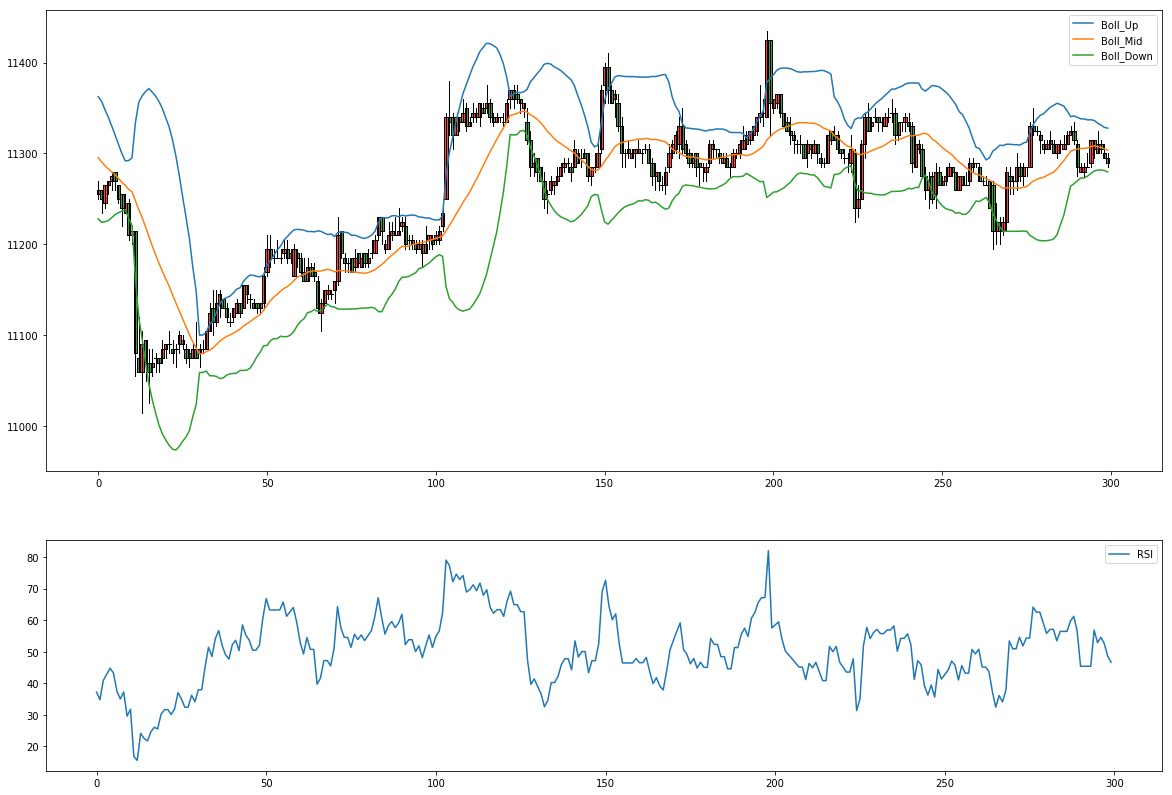

In [7]:
#使用talib库计算常规指标，并绘图


#计算众多指标
def get_factors(data,
                drop=False):
    '''
    :param data: 含Open,High,Low,Close,Volume字段的带时间索引的数据表格
    :return:
    '''
    index=data.index
    Open =data.Open.astype(float).values
    High =data.High.astype(float).values
    Low  =data.Low.astype(float).values
    Close=data.Close.astype(float).values
    Volume=data.Volume.astype(float).values
    
    tmp = pd.DataFrame()
    tmp['tradeTime'] = index

    # 累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    # 用以计算成交量的动量。属于趋势型因子
    tmp['AD'] = talib.AD(High, Low, Close, Volume)

    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    tmp['ADOSC'] = talib.ADOSC(High, Low, Close, Volume, fastperiod=3, slowperiod=10)

    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADX'] = talib.ADX(High, Low, Close, timeperiod=14)

    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADXR'] = talib.ADXR(High, Low, Close, timeperiod=14)

    # 绝对价格振荡指数
    tmp['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26)

    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    # Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    tmp['AROONDown'], tmp['AROONUp'] = talib.AROON(High, Low, timeperiod=14)
    tmp['AROONOSC'] = talib.AROONOSC(High, Low, timeperiod=14)

    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    # 是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    tmp['ATR14'] = talib.ATR(High, Low, Close, timeperiod=14)
    tmp['ATR6']  = talib.ATR(High, Low, Close, timeperiod=6)

    # 布林带
    tmp['Boll_Up'], tmp['Boll_Mid'], tmp['Boll_Down'] = talib.BBANDS(Close, timeperiod=20, nbdevup=2, nbdevdn=2,
                                                                     matype=0)

    # 均势指标
    tmp['BOP'] = talib.BOP(Open, High, Low, Close)

    # 5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    tmp['CCI5'] = talib.CCI(High, Low, Close, timeperiod=5)
    tmp['CCI10'] = talib.CCI(High, Low, Close, timeperiod=10)
    tmp['CCI20'] = talib.CCI(High, Low, Close, timeperiod=20)
    tmp['CCI88'] = talib.CCI(High, Low, Close, timeperiod=88)

    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    tmp['CMO_Close'] = talib.CMO(Close, timeperiod=14)
    tmp['CMO_Open'] = talib.CMO(Close, timeperiod=14)

    # DEMA双指数移动平均线
    tmp['DEMA6'] = talib.DEMA(Close, timeperiod=6)
    tmp['DEMA12'] = talib.DEMA(Close, timeperiod=12)
    tmp['DEMA26'] = talib.DEMA(Close, timeperiod=26)

    # DX 动向指数
    tmp['DX'] = talib.DX(High, Low, Close, timeperiod=14)

    # EMA 指数移动平均线
    tmp['EMA6'] = talib.EMA(Close, timeperiod=6)
    tmp['EMA12'] = talib.EMA(Close, timeperiod=12)
    tmp['EMA26'] = talib.EMA(Close, timeperiod=26)

    # KAMA 适应性移动平均线
    tmp['KAMA'] = talib.KAMA(Close, timeperiod=30)

    # MACD
    tmp['MACD_DIF'], tmp['MACD_DEA'], tmp['MACD_bar'] = talib.MACD(Close, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    tmp['MEDPRICE'] = talib.MEDPRICE(High, Low)

    # 负向指标 负向运动
    tmp['MiNUS_DI'] = talib.MINUS_DI(High, Low, Close, timeperiod=14)
    tmp['MiNUS_DM'] = talib.MINUS_DM(High, Low, timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    # 减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    tmp['MOM'] = talib.MOM(Close, timeperiod=10)

    # 归一化平均值范围
    tmp['NATR'] = talib.NATR(High, Low, Close, timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    # 从而研判股价的走势。属于成交量型因子
    tmp['OBV'] = talib.OBV(Close, Volume)

    # PLUS_DI 更向指示器
    tmp['PLUS_DI'] = talib.PLUS_DI(High, Low, Close, timeperiod=14)
    tmp['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)

    # PPO 价格振荡百分比
    tmp['PPO'] = talib.PPO(Close, fastperiod=6, slowperiod=26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROC6'] = talib.ROC(Close, timeperiod=6)
    tmp['ROC20'] = talib.ROC(Close, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROC6'] = talib.ROC(Volume, timeperiod=6)
    tmp['VROC20'] = talib.ROC(Volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROCP6'] = talib.ROCP(Close, timeperiod=6)
    tmp['ROCP20'] = talib.ROCP(Close, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROCP6'] = talib.ROCP(Volume, timeperiod=6)
    tmp['VROCP20'] = talib.ROCP(Volume, timeperiod=20)

    # RSI
    tmp['RSI'] = talib.RSI(Close, timeperiod=14)

    # SAR 抛物线转向
    tmp['SAR'] = talib.SAR(High, Low, acceleration=0.02, maximum=0.2)

    # TEMA
    tmp['TEMA6'] = talib.TEMA(Close, timeperiod=6)
    tmp['TEMA12'] = talib.TEMA(Close, timeperiod=12)
    tmp['TEMA26'] = talib.TEMA(Close, timeperiod=26)

    # TRANGE 真实范围
    tmp['TRANGE'] = talib.TRANGE(High, Low, Close)

    # TYPPRICE 典型价格
    tmp['TYPPRICE'] = talib.TYPPRICE(High, Low, Close)

    # TSF 时间序列预测
    tmp['TSF'] = talib.TSF(Close, timeperiod=14)

    # ULTOSC 极限振子
    tmp['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

    # 威廉指标
    tmp['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)

    if drop:
        tmp.dropna(inplace=True)

    tmp.set_index('tradeTime', inplace=True)

    return tmp

#画k线图，及附图
def plot_kline(ohlcv_series, mained=None, attached=None):
    '''
    画价格走势k线图，及指定指标附图
    :param ohlcv_series:   含open,high,low,close,volume字段dataframe
    :param main：     主图叠加
    :param attached:  附图叠加
    :return: 
    '''
    if isinstance(mained,pd.Series):
        mained=mained.to_frame()
        
    #print(mained)
        
    gs1 = gridspec.GridSpec(2,1,height_ratios=[2,1])
    plt.figure(figsize=[20,14])
    ax1=plt.subplot(gs1[0])
    #k线（蜡烛图）
    candlestick2_ohlc(ax1,
                      ohlcv_series['Open'],
                      ohlcv_series['High'],
                      ohlcv_series['Low'],
                      ohlcv_series['Close'],
                      width=1,colorup='r',colordown='g')
    #主图叠加
    if mained is not None:
        for col in mained.columns:
            #print(col)
            plt.plot(mained[col].reindex(ohlcv_series.index).values,label=col)
            plt.ion()
        handles1, labels1 = ax1.get_legend_handles_labels()
        ax1.legend(handles1, labels1)
        
    #附图叠加
    if attached is not None:
        ax2=plt.subplot(gs1[1])
        plt.plot(attached.reindex(ohlcv_series.index).values,label=attached.name)
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(handles2, labels2)
        
    plt.show()
    
#计算所有所有指标，作图显示价格k线，主图叠加布林通道，附图显示RSI
factor=get_factors(data,drop=True)
plot_kline(data[-300:],factor[['Boll_Up','Boll_Mid','Boll_Down']],factor['RSI'])
plt.show()

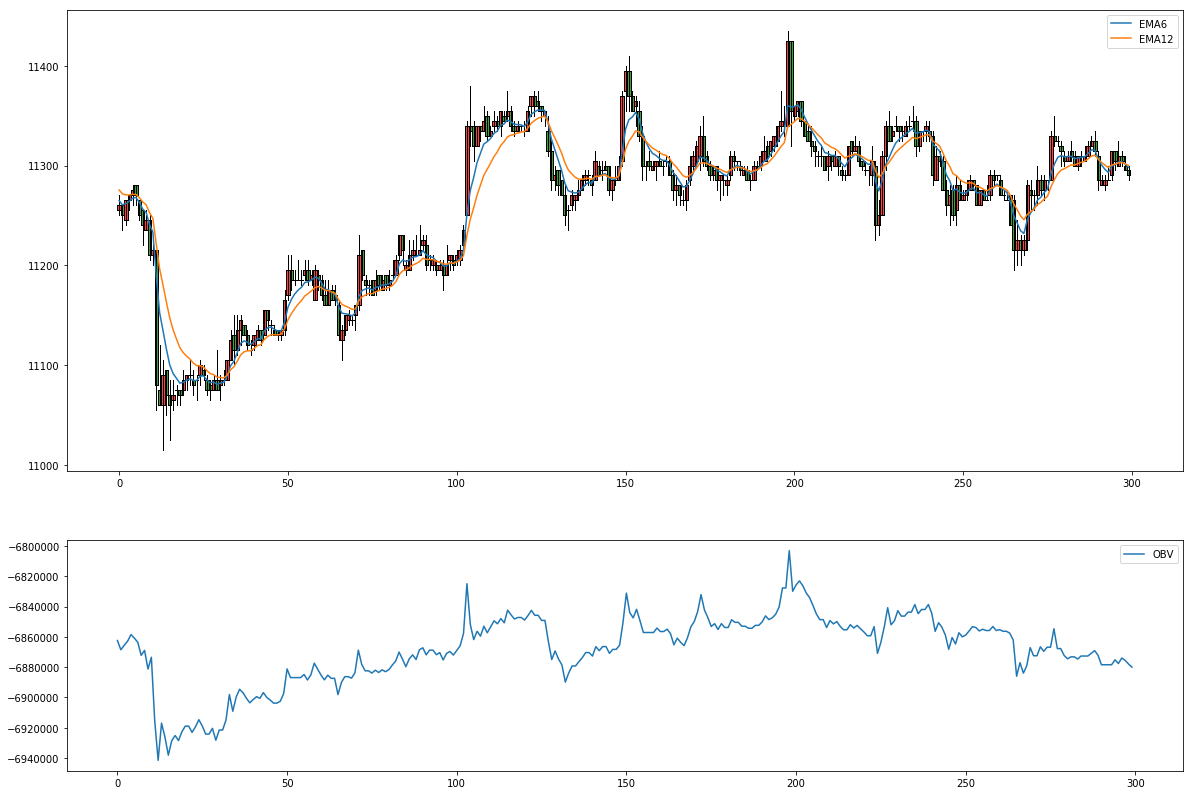

In [23]:
#主图k线， 主图叠加6,12指数加权平均，附图OBV
plot_kline(data[-300:],factor[['EMA6','EMA12']],factor['OBV'])
plt.show()

<h3>2.2.2 talib库其他用法</h3>

talib只能实快速现计算指标，但是无法实现更加复杂的选股公式编辑等功能，因此基于talib指标库，很多人写了不少开源软件，

其中有一个很有意思的项目funcat，它将talib库包装成一个类似于大智慧、通达信的公式编辑器，我们可以通过它，以很方便的

函数语言的方式编辑指标公式、选个股公式等，语法与通达信等非常相似，具有强大的功能。如果读者想实现一些比较复杂的指标，

那么可以考虑使用funcat。

如果有兴趣读者可以参考：https://github.com/cedricporter/funcat  此处不再赘述。

<h2> 2.3 bar的特征（指标）构建 </h2>
通常我们在构建指标的时候可以分成两类，一类是Bar内部的指标，另外一类是Bar之间的指标，我们之前提到的talib指标都是bar之

间的指标。首先说说bar是如何形成的，例如5分钟的bar，我们是先选定了5分钟这样一个时间框架，然后按照5分钟内发生的交易汇总

成bar信息。每一笔交易我们叫一个tick，一般取该5分钟内第一个tick的价格为bar的开盘价，最后一个tick的价格为bar收盘价，所有

tick的最高价为bar的最高价，所有tick的最低价为bar的最低价，所有tick成交量合计为bar的成交量，一个bar就这么形成，此时这个

bar有open,high,low,close,volume五个最基本的指标。如果我们想赋予bar更多信息，而这些信息只是用此bar内发生的tick汇总得到，

那么这些指标就是bar内指标，比如bar内价格峰度、价格回归斜率、主动买比例、主动卖比例等，这些指标是在成bar时候形成的，和前

后别的bar没关系。而类似于talib这样的指标，是成bar之后，再计算bar之间的具有时间先后顺序的指标，比如价格指数移动平均，

它需要用到前面N个bar的收盘价，这样的指标叫Bar间指标。

<h3>2.3.1 通过tick汇总bar内指标</h3>

Bar间指标在讲talib库章节已经有描述，基础课程模型基本上用talib指标就可以了，下面我们讲讲如何通过tick汇总其他的bar内指标。

虽然基础课程建模并没有用到tick汇总的其他bar内指标，但有可能在将来的高级课程中用到。

In [8]:
#读取tick数据
import talib

def get_tick_data(filename):
    ticks=pd.read_pickle(filename)
    ticks.sort_index(inplace=True)
    return ticks

#统计买量
def lambda_bs(x,flag):
    buy=0
    for i in x.itertuples():
        if i.BSFLAG==flag:
            buy+=i.VOLUME
    return buy

#用tick数据汇总5分钟的bar
def gen_bar(tick_df,feq):
    datetime=tick_df.resample(feq).last().index   #一般用最后时间作为bar时间
    open  = tick_df['LASTPRICE'].resample(feq).first()  #开盘价
    high  = tick_df['LASTPRICE'].resample(feq).max()    #最高价
    low   = tick_df['LASTPRICE'].resample(feq).min()    #最低价
    close = tick_df['LASTPRICE'].resample(feq).last()   #收盘价
    volume= tick_df['VOLUME'].resample(feq).sum()       #成交量
    buyvolume =tick_df.resample(feq).apply(lambda x:lambda_bs(x,'B')) #主动买量
    sellvolume=tick_df.resample(feq).apply(lambda x:lambda_bs(x,'S')) #主动卖量
    
    open.name='open'
    high.name='high'
    low.name='low'
    close.name='close'
    volume.name='volume'
    buyvolume.name='buyvolume'
    sellvolume.name='sellvolume'
    
    #...其他想要添加的指标
    bar=[open,high,low,close,volume,buyvolume,sellvolume]
    bar=pd.concat(bar,1)
    bar.dropna(how='any',inplace=True)
    bar.sort_index(inplace=True)
    return bar
    
#读取tick文件，展示其结构
ticks=get_tick_data('C:\\HiData\\Users\\ShenHong\\合作\\融秀\\AI量化初级\\notebook\\ru_main_ticks.pkl')
print('tick记录数：%d \n'%len(ticks))
print('全部属性：',ticks.columns.tolist())
print('\n主要属性：\n LASTPRICE 最新价 \n VOLUME 成交量 \n BSFLAG 买卖标志 \n')
print(ticks.iloc[-30:][['LASTPRICE','VOLUME','BSFLAG']])
print()

#汇bar
bars=gen_bar(ticks,'5T') #5T表示5分钟频率
print('汇成bar之后：')
print(bars[-10:])

tick记录数：200000 

全部属性： ['MARKETCODE', 'INSTRUMENTID', 'TRADINGTIME', 'LASTPRICE', 'OPENINTEREST', 'ADDINTEREST', 'AMOUNT', 'VOLUME', 'OPENVOLUME', 'CLOSEVOLUME', 'TRADETYPE', 'BSFLAG', 'BIDPRICE1', 'ASKPRICE1', 'BIDVOLUME1', 'ASKVOLUME1']

主要属性：
 LASTPRICE 最新价 
 VOLUME 成交量 
 BSFLAG 买卖标志 

                         LASTPRICE  VOLUME BSFLAG
datetime                                         
2018-10-31 14:59:46.500    11230.0      18      B
2018-10-31 14:59:47.000    11230.0       4      B
2018-10-31 14:59:47.500    11225.0       2      S
2018-10-31 14:59:48.000    11230.0      16      B
2018-10-31 14:59:48.500    11225.0       8      S
2018-10-31 14:59:49.000    11230.0       4      B
2018-10-31 14:59:49.500    11230.0       2      B
...                            ...     ...    ...
2018-10-31 14:59:58.000    11235.0      56      B
2018-10-31 14:59:58.500    11235.0       2      B
2018-10-31 14:59:59.000    11230.0      10      S
2018-10-31 14:59:59.500    11230.0      20      S
2018-10-31

汇成bar之后：
                        open     high      low    close  volume  buyvolume  \
datetime                                                                     
2018-10-31 14:20:00  11270.0  11270.0  11240.0  11245.0    6640       3426   
2018-10-31 14:25:00  11245.0  11260.0  11240.0  11245.0    3778       1784   
2018-10-31 14:30:00  11240.0  11250.0  11240.0  11245.0    3216       1726   
2018-10-31 14:35:00  11245.0  11255.0  11235.0  11250.0    3624       2006   
2018-10-31 14:40:00  11250.0  11250.0  11235.0  11240.0    2398        750   
2018-10-31 14:45:00  11240.0  11250.0  11235.0  11245.0    2332       1176   
2018-10-31 14:50:00  11245.0  11255.0  11235.0  11245.0    3942       2172   
2018-10-31 14:55:00  11240.0  11245.0  11225.0  11230.0    6998       2612   
2018-10-31 15:00:00  11230.0  11230.0  11230.0  11230.0      86          0   
2018-10-31 15:20:00  11230.0  11230.0  11230.0  11230.0       0          0   

                     sellvolume  
datetime            

<h2>2.4 特征缩放 </h2>

每个特征的范围往往是不一样的而且差异非常大，比如波动率一般是百分之几到千分之几，但是累计成交量可能会是几百万，

如果我们不加以处理直接输入模型，对于有些类型的机器学习模型（比如神经网络、深度学习）等是不合适的，值比较大的

属性往往会被突出，而值比较小的可能会被忽略，因此有必要将每个特征的范围缩放到基本相同的范围。但是特征缩放，也不是

任何模型都需要的，比如Tree（决策树），Random Forest（随机森林），XGB等主要靠判断来分类的可能不一定需要做标准化，

而对于神经网络，深度学习等通过学习权重的模型，则必须做标准化。

<h3>2.4.1 常用标准化 </h3>

常用的标准化方法是： X2 = (X1 - X1均值)/X1标准差    其中X1是未标准化的序列，X2是标准化以后的序列。

X1的长度可以是所有数据，这样就是全局标准化，也可以是一个滚动的窗口，每次标准化只在这个窗口内，窗口

依次前滚。全局标准化可能会存在衔接问题，就是训练的时候标准化均值和标准差，和测试数据集未必相同，因此

为了避免这个问题，建议可以采用滚动标准化的办法。

In [17]:
#函数：一般的标准化
def get_roll_std(df,rolling=26):
    '''
    :param df:       需要标准化的dataframe
    :param rolling:  是否要rolling(rolling>0则rolling，否则不做）
    :return: 
    '''
    _df=df.copy(deep=True)
    
    factors_list=_df.columns.tolist()

    if rolling>0:
        for i in factors_list:
            _df[i] = (_df[i] - _df[i].rolling(window=rolling, center=False).mean()) / _df[i].rolling(window=rolling, center=False).std()
    else:
        for i in factors_list:
            _df[i] = (_df[i] - _df[i].mean()) / _df[i].std()
            
    _df.dropna(how='any',inplace=True)
    return _df
            
print('rolling标准化后bars的数据（可以对比前面未标准化的数据）：')
bars2=get_roll_std(bars,10)
print(bars2[-10:])

rolling标准化后bars的数据（可以对比前面未标准化的数据）：
                         open      high       low     close    volume  \
datetime                                                                
2018-10-31 14:20:00  1.181113  0.623531  0.875135  0.515425 -0.011826   
2018-10-31 14:25:00  0.471062  0.302690  0.733631  0.401537 -0.451042   
2018-10-31 14:30:00  0.249136 -0.036142  0.583934  0.287883 -0.502324   
2018-10-31 14:35:00  0.260623 -0.012667  0.340777  0.310414 -0.469372   
2018-10-31 14:40:00  0.283193 -0.262114  0.235793 -0.088852 -0.654881   
2018-10-31 14:45:00 -0.118876 -0.449256  0.124838 -0.082761 -0.692950   
2018-10-31 14:50:00 -0.117010 -0.588695 -0.079057 -0.573161 -0.466096   
2018-10-31 14:55:00 -0.784772 -0.852750 -1.198756 -1.456247  0.290781   
2018-10-31 15:00:00 -1.225043 -1.797233 -0.755180 -1.407843 -1.787439   
2018-10-31 15:20:00 -1.192984 -1.579064 -0.905042 -1.378058 -1.421371   

                     buyvolume  sellvolume  
datetime                                   

<h3> 2.4.3 缩放到指定范围 </h3>

还有一种常用的标准化方法，就是缩放到一个指定的范围，比如经常是缩放到[-1,1]或者[0,1]之间。

因为，有些模型中的过程或者函数对[0,1]范围值比较敏感，比如深度学习中，网络最后一层softmax处理，

或者激活sigmod函数，都对[0,1]比较敏感，因此针对此类模型需要进行缩放到该范围。

我们可以使用sklearn包下面的数据处理preprocessing模块中MinMaxScaler函数将数据缩放到一个指定的

范围。


In [24]:
import sklearn.preprocessing as preprocessing

min_max_scaler=preprocessing.MinMaxScaler(feature_range=(0,1)) #创建类的实例，指定缩放到(0,1)范围
bar_minmax=min_max_scaler.fit_transform(bars.values)
print('缩放后后属性范围：')
print(bar_minmax)

缩放后后属性范围：
[[0.93641618 0.92528736 0.94252874 ... 0.03380559 0.03288847 0.03321555]
 [0.93641618 0.9137931  0.94827586 ... 0.         0.         0.        ]
 [0.93641618 0.9137931  0.92528736 ... 0.07870917 0.05215852 0.1090106 ]
 ...
 [0.10404624 0.09195402 0.10344828 ... 0.13770169 0.08892823 0.19372792]
 [0.09248555 0.07471264 0.1091954  ... 0.00169225 0.         0.00379859]
 [0.09248555 0.07471264 0.1091954  ... 0.         0.         0.        ]]


<h2>2.5 特征相关性分析 </h2>
每个bar的特征并不是越多越好，因为很多特征都是通过同样的数据计算出来，特征之间相关性很高。

相关性很高的特征放在一起输入模型训练，会产生所谓的“共线性”问题，产生不良的影响，比如

参数估计量不存在，变量显著性检验失去意义，模型的预测功能失效等。因此最直接的办法，就是

排除引起共线性的变量。所以，在特征构建完之后，需要做相关性分析，剔除相关性较高的特征。

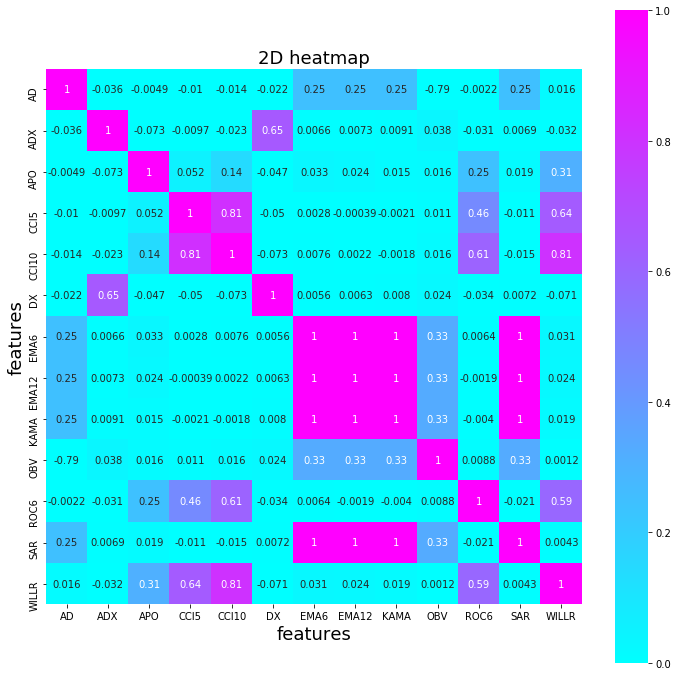

In [14]:
import seaborn as sns

#函数：画相关系数热图
def plot_corr_heatmap(df):
    a = np.random.rand(4,3)
    fig, ax = plt.subplots(figsize = (12,12))
    #二维的数组的热力图，横轴和数轴的ticklabels要加上去的话，既可以通过将array转换成有column
    #和index的DataFrame直接绘图生成，也可以后续再加上去。后面加上去的话，更灵活，包括可设置labels大小方向等。
    sns.heatmap(df, annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True,cmap=plt.cm.cool)
    #sns.heatmap(np.round(a,2), annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, 
    #            square=True, cmap="YlGnBu")
    ax.set_title('2D heatmap', fontsize = 18)
    ax.set_ylabel('features', fontsize = 18)
    ax.set_xlabel('features', fontsize = 18) 
    
plot_corr_heatmap(factor[['AD','ADX','APO','CCI5','CCI10','DX','EMA6','EMA12','KAMA','OBV','ROC6','SAR','WILLR']].corr())

从上面热力图可以看出，排除中间属性自己和自己的相关性肯定为1，其他比如WILLR和CCI10相关性是0.81，

WILLR和ROC6相关性为0.59，ROC6和CCI10相关性也很高，这三者相关性较高，可以考虑去掉其中2个。

另外，比如CCI5和CCI10相关性也很高，EMA6和EMA12以及KAMA相关性很高，每一类只需要保留一个即可。

<h2>2.6 特征重要性分析 </h2>

特征重要性分析在建模之前也是很重要的步骤，通过对特征重要性的排列，我们可以了解到哪些属性提供了正向的帮助，

对于模型的预测能力比较重要，哪些属性不但没有起到正向帮助，反而降低了模型预测能力，是应该被去掉的。属性

重要性分析是基于模型的，不同模型对于不同特征有不同表现。在此，我们采用随机森林模型建模，分析不同特征的重要性。

关于决策树、随机森林模型，将在下章节详细展开。



C:\HiData\Software\Anaconda3\envs\py36-shen\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Feature ranking:
1. feature CCI5 (0.344836)
2. feature WILLR (0.259026)
3. feature APO (0.052037)
4. feature DX (0.045287)
5. feature Volume (0.044782)
6. feature ADX (0.041780)
7. feature SAR (0.036975)
8. feature AD (0.036749)
9. feature OBV (0.035933)
10. feature EMA6 (0.034493)
11. feature High (0.034122)
12. feature Close (0.033980)


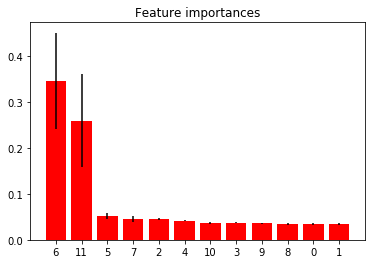

In [22]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

def feature_imp(X,y):
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    colname = X.columns
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, colname[indices[f]], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])

comb=pd.concat([data,factor],1)
feats=['High','Close','Volume','AD','ADX','APO','CCI5','DX','EMA6','OBV','SAR','WILLR']
X=comb[feats]
X.dropna(how='any',inplace=True)
y=get_labeling(X['Close'],5)
X=X.reindex(y.index)
feature_imp(X,y)
plt.show()